In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import random
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img
import os
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.metrics import confusion_matrix, classification_report

In [19]:

def load_dataset(directory):
    images, labels = [], []
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    for category in categories:
        path_to_category = os.path.join(directory, category)
        if os.path.isdir(path_to_category):
            for file in os.listdir(path_to_category):
                full_path = os.path.join(path_to_category, file)
                if os.path.isfile(full_path):
                    with Image.open(full_path) as img:
                        img = img.resize((128, 128)).convert('RGB')
                        images.append(np.array(img))
                        labels.append(category)
    return images, labels

def convert_labels_to_one_hot(labels):
    if not labels:
        raise ValueError("No labels found. Ensure the dataset is loaded correctly.")
    label_encoder = OneHotEncoder(sparse_output=False)
    labels_as_array = np.array(labels).reshape(-1, 1)
    one_hot_labels = label_encoder.fit_transform(labels_as_array)
    return one_hot_labels

In [23]:
# Load training data
training_folder = 'archive/Training'
train_images, train_labels = load_dataset(training_folder)
train_labels_one_hot = convert_labels_to_one_hot(train_labels)



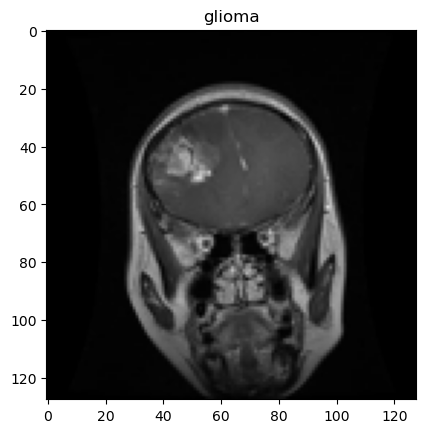

In [27]:
plt.imshow(train_images[0])
plt.title(train_labels[0])
plt.show()

In [29]:
# Load testing data
testing_folder = 'archive/Testing'
test_images, test_labels = load_dataset(testing_folder)
test_labels_one_hot = convert_labels_to_one_hot(test_labels) #convert the test label to one hot encoded vector


In [32]:
# Converting images to numpy arrays and normalize
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0


In [31]:

print(f"Training data shape: {train_images.shape}, Training labels shape: {train_labels_one_hot.shape}")
print(f"Testing data shape: {test_images.shape}, Testing labels shape: {test_labels_one_hot.shape}")



Training data shape: (5712, 128, 128, 3), Training labels shape: (5712, 4)
Testing data shape: (1311, 128, 128, 3), Testing labels shape: (1311, 4)


In [34]:
# Shuffle training data and labels
shuffle_index = np.random.permutation(len(train_images))
train_images = train_images[shuffle_index]
train_labels_one_hot = train_labels_one_hot[shuffle_index]


In [36]:
# Define class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

### Plotting some of the images

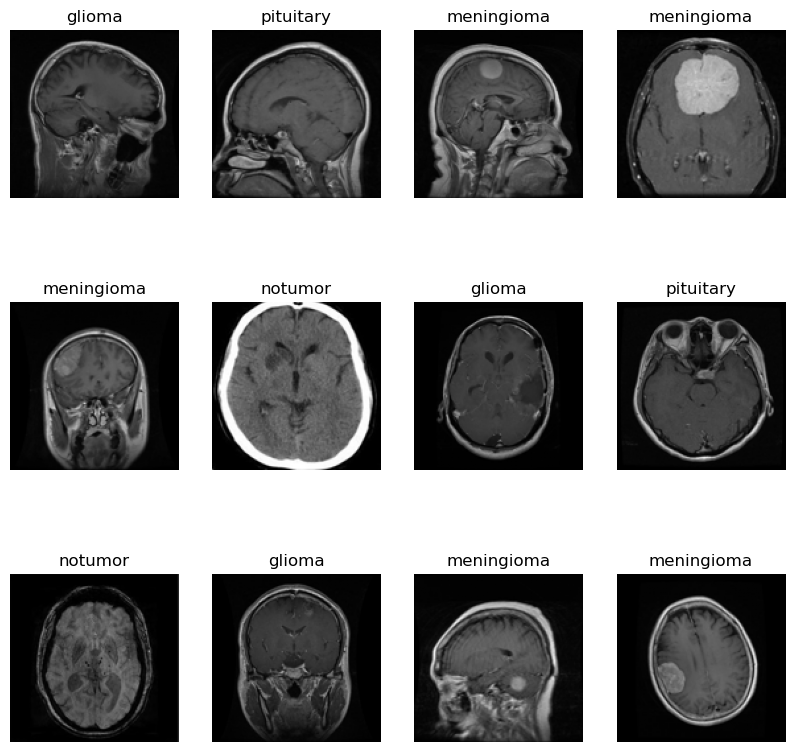

In [40]:
plt.figure(figsize=(10, 10))
indices = np.random.choice(len(train_images), 12, replace=False)

for i, idx in enumerate(indices):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(train_images[idx])
    plt.title(class_labels[np.argmax(train_labels_one_hot[idx])])
    plt.axis('off')

plt.show()

In [42]:

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)


In [69]:
train_generator = datagen.flow(train_images, train_labels_one_hot, batch_size=32)

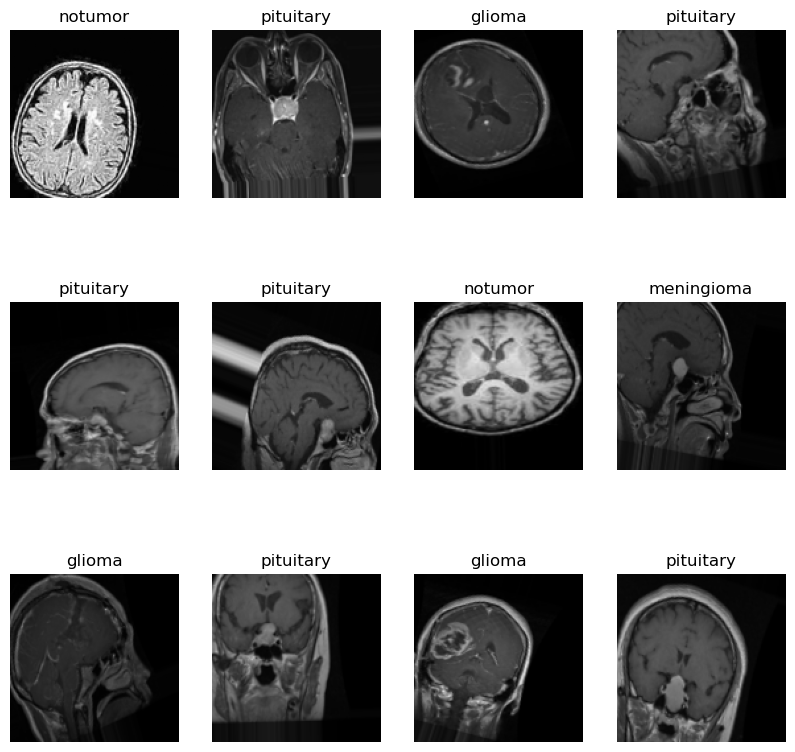

In [70]:
# For demonstration, plot augmented images
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    break  # Only take the first batch for plotting

plt.show()

In [72]:

# Load the ResNet50 model pretrained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 46s 0us/step


In [73]:
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [74]:

# Add a dense output layer with 4 neurons (one for each class) and softmax activation
predictions = Dense(4, activation='softmax')(x)

# Combine the base model and the new layers
model = Model(inputs=base_model.input, outputs=predictions)


In [75]:
for layer in base_model.layers:
    layer.trainable = False


In [76]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [77]:
# Train the model using the generator
train_generator = datagen.flow(train_images, train_labels_one_hot, batch_size=32)
history = model.fit(train_generator, epochs=10, validation_data=(test_images, test_labels_one_hot))


Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 575ms/step - accuracy: 0.3036 - loss: 1.4040 - val_accuracy: 0.3402 - val_loss: 1.2520
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 100s 552ms/step - accuracy: 0.4149 - loss: 1.2630 - val_accuracy: 0.3646 - val_loss: 1.2644
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 561ms/step - accuracy: 0.4630 - loss: 1.2109 - val_accuracy: 0.4005 - val_loss: 1.2586
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 557ms/step - accuracy: 0.4944 - loss: 1.1850 - val_accuracy: 0.4043 - val_loss: 1.2556
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 559ms/step - accuracy: 0.5033 - loss: 1.1605 - val_accuracy: 0.4218 - val_loss: 1.2395
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 557ms/step - accuracy: 0.4892 - loss: 1.1608 - val_accuracy: 0.4340 - val_loss: 1.2619
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 555ms/step - accuracy: 0.5201 - loss: 1.1328 - val_accuracy: 0.4699 - val_loss: 1.2339
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 557ms/step - accuracy: 0.5318 - loss: 1.11

In [78]:
for layers in base_model.layers:
    layers.trainable = False
    
topLayer = Flatten()(base_model.output)
topLayer = Dropout(0.5)(topLayer)
topLayer = Dense(4, activation = "softmax")(topLayer)
model = Model(base_model.input, topLayer)

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.F1Score()])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,718,788 (90.48 MB)

 Trainable params: 131,076 (512.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
ESM = tf.keras.callbacks.EarlyStopping(patience=4, monitor='accuracy')
rn = model.fit(train_generator, epochs=30, validation_data=(test_images, test_labels_one_hot))

Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 582ms/step - accuracy: 0.3773 - auc: 0.6464 - f1_score: 0.3614 - loss: 0.5526 - precision: 0.4681 - recall: 0.2101 - val_accuracy: 0.4821 - val_auc: 0.7363 - val_f1_score: 0.3923 - val_loss: 0.5125 - val_precision: 0.5875 - val_recall: 0.3791
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 100s 554ms/step - accuracy: 0.4557 - auc: 0.7308 - f1_score: 0.4470 - loss: 0.4908 - precision: 0.5322 - recall: 0.3340 - val_accuracy: 0.4989 - val_auc: 0.7406 - val_f1_score: 0.3954 - val_loss: 0.5179 - val_precision: 0.5433 - val_recall: 0.4455
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 561ms/step - accuracy: 0.4853 - auc: 0.7529 - f1_score: 0.4774 - loss: 0.4766 - precision: 0.5640 - recall: 0.3584 - val_accuracy: 0.5393 - val_auc: 0.7650 - val_f1_score: 0.4811 - val_loss: 0.5251 - val_precision: 0.6103 - val_recall: 0.4432
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 562ms/step - accuracy: 0.5131 - auc: 0.7717 - f1_score: 0.5022 - loss: 0.4648 - precision: 